<a href="https://colab.research.google.com/github/ClauCll/Curso_ML_A_Z/blob/master/Regresi%C3%B3n/Regresion_Bajas_Antiguedad_v5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Cuantas serán las bajas voluntarias de los clientes fijos para el periodo 202009 - 202012
 

In [57]:
import pandas as pd
import numpy as np

#Gráfico
from mpl_toolkits.mplot3d import axes3d
import matplotlib.pyplot as plt 
from matplotlib import style
import matplotlib.ticker as ticker
import seaborn as sns

import gspread
from oauth2client.client import GoogleCredentials 
from google.colab import auth
# Autoriza Claudia
auth.authenticate_user()
gc = gspread.authorize (GoogleCredentials.get_application_default())

### leemos datos

In [58]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [67]:
data = pd.read_csv('/content/drive/My Drive/Dataset/BAJAS.txt',delimiter='~')
data = data[['MES_BAJA','TRIM_1','TRIM_2','TRIM_3','TRIM_4','ENTRE_1_2_ANIOS','ENTRE_3_4_ANIOS','MAS_5_ANIOS','TOTAL_BAJAS']]
data = data.groupby(['MES_BAJA']).agg({"MES_BAJA":'median',"TRIM_1": 'median',"TRIM_2": 'median',
                                "TRIM_3": 'median',"TRIM_4": 'median',  
                                "ENTRE_1_2_ANIOS": 'median',"ENTRE_3_4_ANIOS": 'median',
                                "MAS_5_ANIOS": 'median',"TOTAL_BAJAS": 'median'})
X  = data.iloc[:,:-1].values
Y  = data.iloc[:,8]
Y = Y[:,np.newaxis]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:9: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  if __name__ == '__main__':


In [68]:
# Estadísticas para todas las columnas numéricas por sexo
data.describe()
# Regresa la media de cada columna numérica por sexo
#data.mean()

,MES_BAJA,TRIM_1,TRIM_2,TRIM_3,TRIM_4,ENTRE_1_2_ANIOS,ENTRE_3_4_ANIOS,MAS_5_ANIOS,TOTAL_BAJAS
count,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000,12.000000
mean,6.500000,40.166667,23.041667,21.916667,195.541667,623.000000,448.750000,34.083333,1386.500000
std,3.605551,12.716012,8.161602,4.415023,60.842740,132.103265,328.289887,29.826646,424.848315
min,1.000000,19.000000,15.000000,15.000000,134.000000,470.000000,294.000000,6.000000,978.000000
25%,3.750000,30.500000,18.875000,19.375000,162.750000,533.625000,308.625000,17.000000,1093.250000
50%,6.500000,40.250000,19.500000,21.750000,173.250000,596.500000,343.500000,21.250000,1283.250000
75%,9.250000,49.125000,23.625000,24.125000,211.750000,691.500000,405.250000,42.875000,1501.625000
max,12.000000,59.500000,43.500000,31.500000,343.000000,924.500000,1470.000000,105.000000,2435.000000


In [ ]:
data

In [ ]:
Y

In [70]:
X.shape

(12, 8)

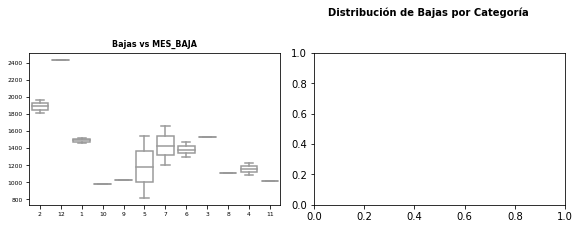

In [14]:
# Gráfico relación entre el precio y cada cada variables cualitativas
# ==============================================================================
# Ajustar número de subplots en función del número de columnas
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(12, 8))
axes = axes.flat
columnas_object = data.select_dtypes(include=['object']).columns

for i, colum in enumerate(columnas_object):
    sns.boxplot (
        x     = colum,
        y     = 'TOTAL_BAJAS',
        data  = data,
        color = "white",
        ax    = axes[i]
    )
    axes[i].set_title(f"Bajas vs {colum}", fontsize = 8, fontweight = "bold")
    axes[i].yaxis.set_major_locator(ticker.AutoLocator())
    axes[i].tick_params(labelsize = 6)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Se eliminan los axes vacíos
for i in [2,3,4,5,6,7,8]:
   fig.delaxes(axes[i])
    
fig.tight_layout()
plt.subplots_adjust(top=0.9)
fig.suptitle('Distribución de Bajas por Categoría', fontsize = 10, fontweight = "bold");

In [ ]:
#pasamos las variables cualitativas a binarias
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

labelencoder= LabelEncoder()
X[:,0]= labelencoder.fit_transform(X[:,0])
X[:,1]= labelencoder.fit_transform(X[:,1])

ct = ColumnTransformer([('one_hot_encoder',OneHotEncoder(categories='auto'),[0,1])],remainder='passthrough')
X=np.array(ct.fit_transform(X),dtype=np.int)

X = X[:,1:]


In [ ]:
#selección de caracteristicas basadas en L1
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

lsvc = LinearSVC(C=0.01, penalty="l1", dual=False).fit(X, Y)
model = SelectFromModel(lsvc, prefit=True)
X2 = model.transform(X)
X2.shape

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


(19, 5)

In [ ]:
pd.DataFrame(X2)

In [ ]:
# Datos en entrenamiento y test.
# ==============================================================================
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(X2, Y,train_size = 0.8,
                                        random_state = 0,
                                        shuffle      = True
                                    )
#escalamos los datos
from sklearn.preprocessing import StandardScaler
sc_x = StandardScaler()
sc_y = StandardScaler()
x_train = sc_x.fit_transform(x_train)
y_train= sc_y.fit_transform(y_train)
x_test = sc_x.fit_transform(x_test)
y_test= sc_y.fit_transform(y_test)


In [ ]:
pd.DataFrame(x_train)

In [ ]:
x_train

## Modelo SVM

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.svm import SVR

svr= SVR(kernel='rbf',degree=3, C=1.0, epsilon=0.2)
svr.fit(x_train,y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.2, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [ ]:
y_predic = svr.predict(x_train)

In [ ]:
print(svr.score(x_train,y_train))
print(svr.score(x_test,y_test))

0.949768234950482
0.205026654700323


In [ ]:
x_test

In [ ]:
y_predic

array([-0.66786437, -0.18962612,  0.75040555, -0.08149598])